## This script is to convert recorded demonstrations (from rosbag format) to samples (in txt format) to conform with the TP-GMM code.

In [128]:
import rosbag
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
# from franka_msgs.msg import FrankaState

# main_dir = "/home/zizo/Disassembly Teleop/"
# TPGMM_dir = "/home/zizo/myGithubRepos/Task-Parameterized-Gaussian-Mixture-Model/"
main_dir = "C:/Users/AWasf/OneDrive/Desktop/PhD Lab Work/Disassembly-Teleop/"
TPGMM_dir = "C:/Users/AWasf/OneDrive/Desktop/PhD Lab Work/TP-GMM/"

### 2D

In [8]:
task_name = "Rcover"
task_num = str(3)

demon_bag = rosbag.Bag(main_dir + "Demons/" + task_name + "/action/Franka_Stage2_" + task_name + "_action_Demon" + task_num + ".bag", 'r')

data_topic = "/panda_teleop/follower_state_controller/franka_states"

conc_arr_Data = np.zeros((3,1))
msg_count = 0
for topic, msg, t in demon_bag.read_messages(data_topic):

    # Preparing the Data points matrix from the Demons
    # arr_Data = np.array([[msg.O_T_EE[12]], [msg.O_T_EE[13]], [msg.O_T_EE[14]]]) # TODO: add the erro_pose value
    arr_Data = np.array([[sqrt(msg.O_T_EE_c[12]**2 + msg.O_T_EE_c[13]**2 + msg.O_T_EE_c[14]**2)], [msg.O_T_EE[12]], [msg.O_T_EE[14]]]) # Euc. distance of error_pose

    conc_arr_Data = np.concatenate((conc_arr_Data, arr_Data), axis=1)

    # Preparing the b matrix & A matrix for frame 1 (Position & RotationMatrix of the Starting point(frame) of the Demon w.r.t the base frame of the robot (panda_link0))
    if (msg_count == 0):
        # arr_frame1_b = np.array([[msg.O_T_EE[12]], [msg.O_T_EE[13]], [msg.O_T_EE[14]]])
        # arr_frame1_A = np.matrix([[msg.O_T_EE[0], msg.O_T_EE[4], msg.O_T_EE[8]],
        #                           [msg.O_T_EE[1], msg.O_T_EE[5], msg.O_T_EE[9]],
        #                           [msg.O_T_EE[2], msg.O_T_EE[6], msg.O_T_EE[10]]])
        arr_frame1_b = np.array([[0.0], [msg.O_T_EE[12]], [msg.O_T_EE[14]]])
        arr_frame1_A = np.matrix([[msg.O_T_EE[0], 0, msg.O_T_EE[8]],
                                              [0, 1, 0],
                                  [msg.O_T_EE[2], 0, msg.O_T_EE[10]]])    

    # Preparing the b matrix & A matrix for frame 2 (Position & RotationMatrix of the Ending point(frame) of the Demon w.r.t the base frame of the robot (panda_link0))
    # arr_frame2_b = np.array([[msg.O_T_EE[12]], [msg.O_T_EE[13]], [msg.O_T_EE[14]]])
    # arr_frame2_A = np.matrix([[msg.O_T_EE[0], msg.O_T_EE[4], msg.O_T_EE[8]],
    #                           [msg.O_T_EE[1], msg.O_T_EE[5], msg.O_T_EE[9]],
    #                           [msg.O_T_EE[2], msg.O_T_EE[6], msg.O_T_EE[10]]])
    arr_frame2_b = np.array([[0.0], [msg.O_T_EE[12]], [msg.O_T_EE[14]]])
    arr_frame2_A = np.matrix([[msg.O_T_EE[0], 0, msg.O_T_EE[8]],
                                          [0, 1, 0],
                              [msg.O_T_EE[2], 0, msg.O_T_EE[10]]])
            
    msg_count += 1
demon_bag.close()
print("Number of data points in Demo {}: {}".format(task_num, msg_count))

# Filling in b matrix & A matrix for frame 1
conc_arr_frame1_b = np.ones((3, msg_count)) * arr_frame1_b
conc_arr_frame1_A = np.tile(arr_frame1_A.T, msg_count) # the .T is because the rotation is around negative y-axis

# Filling in b matrix & A matrix for frame 2
conc_arr_frame2_b = np.ones((3, msg_count)) * arr_frame2_b
conc_arr_frame2_A = np.tile(arr_frame2_A.T, msg_count)

# Saving in txt files
np.savetxt(TPGMM_dir + "Demon" + task_num + "_sample_Data.txt", conc_arr_Data[:,1:], fmt='%.5f') # cut out the 1st column (zeros) that was created only to initialize the array 
np.savetxt(TPGMM_dir + "Demon" + task_num + "_sample_frame1_b.txt", conc_arr_frame1_b, fmt='%.5f')
np.savetxt(TPGMM_dir + "Demon" + task_num + "_sample_frame1_A.txt", conc_arr_frame1_A, fmt='%.5f')
np.savetxt(TPGMM_dir + "Demon" + task_num + "_sample_frame2_b.txt", conc_arr_frame2_b, fmt='%.5f')
np.savetxt(TPGMM_dir + "Demon" + task_num + "_sample_frame2_A.txt", conc_arr_frame2_A, fmt='%.5f')

# Add the ',' to put file in the format that TP-GMM code accepts
with open(r"{}".format(TPGMM_dir) + "Demon" + task_num + "_sample_Data.txt", 'r') as f: # The 'r' before the directory name is to open the file as read-only
    data = f.read(); data = data.replace(' ', ',')
with open(r"{}".format(TPGMM_dir) + "Demon" + task_num + "_sample_Data.txt", 'w') as f:
    f.write(data)
    
with open(r"{}".format(TPGMM_dir) + "Demon" + task_num + "_sample_frame1_b.txt", 'r') as f:
    data = f.read(); data = data.replace(' ', ',')
with open(r"{}".format(TPGMM_dir) + "Demon" + task_num + "_sample_frame1_b.txt", 'w') as f:
    f.write(data)

with open(r"{}".format(TPGMM_dir) + "Demon" + task_num + "_sample_frame1_A.txt", 'r') as f:
    data = f.read(); data = data.replace(' ', ',')
with open(r"{}".format(TPGMM_dir) + "Demon" + task_num + "_sample_frame1_A.txt", 'w') as f:
    f.write(data)

with open(r"{}".format(TPGMM_dir) + "Demon" + task_num + "_sample_frame2_b.txt", 'r') as f:
    data = f.read(); data = data.replace(' ', ',')
with open(r"{}".format(TPGMM_dir) + "Demon" + task_num + "_sample_frame2_b.txt", 'w') as f:
    f.write(data)

with open(r"{}".format(TPGMM_dir) + "Demon" + task_num + "_sample_frame2_A.txt", 'r') as f:
    data = f.read(); data = data.replace(' ', ',')
with open(r"{}".format(TPGMM_dir) + "Demon" + task_num + "_sample_frame2_A.txt", 'w') as f:
    f.write(data)

Number of data points in Demo 3: 851


### 3D

In [136]:
for d in range(1,4):
    task_name = "Rcover"
    task_num = str(d)

    demon_bag = rosbag.Bag(main_dir + "Demons/" + task_name + "/action/Franka_Stage2_" + task_name + "_action_Demon" + task_num + ".bag", 'r')

    data_topic = "/panda_teleop/follower_state_controller/franka_states"

    conc_arr_Data = np.zeros((4,1))
    msg_count = 0
    for topic, msg, t in demon_bag.read_messages(data_topic):

        # Preparing the Data points matrix from the Demons
        # arr_Data = np.array([[msg.O_T_EE[12]], [msg.O_T_EE[13]], [msg.O_T_EE[14]]]) # TODO: add the erro_pose value
        # arr_Data = np.array([[sqrt(msg.O_T_EE_c[12]**2 + msg.O_T_EE_c[13]**2 + msg.O_T_EE_c[14]**2)], [msg.O_T_EE[12]], [msg.O_T_EE[13]], [msg.O_T_EE[14]]]) # Euc. distance of error_pose
        arr_Data = np.array([[msg.O_T_EE_c[0]], [msg.O_T_EE[12]], [msg.O_T_EE[13]], [msg.O_T_EE[14]]]) # Euc. distance of error_pose

        conc_arr_Data = np.concatenate((conc_arr_Data, arr_Data), axis=1)

        # Preparing the b matrix & A matrix for frame 1 (Position & RotationMatrix of the Starting point(frame) of the Demon w.r.t the base frame of the robot (panda_link0))
        if (msg_count == 0):
            arr_frame1_b = np.array([[0], [msg.O_T_EE[12]], [msg.O_T_EE[13]], [msg.O_T_EE[14]]])
            arr_frame1_A = np.matrix([[1,             0,             0,             0],
                                    [0, msg.O_T_EE[0], msg.O_T_EE[4], msg.O_T_EE[8]],
                                    [0, msg.O_T_EE[1], msg.O_T_EE[5], msg.O_T_EE[9]],
                                    [0, msg.O_T_EE[2], msg.O_T_EE[6], msg.O_T_EE[10]]])

        # Preparing the b matrix & A matrix for frame 2 (Position & RotationMatrix of the Ending point(frame) of the Demon w.r.t the base frame of the robot (panda_link0))
        arr_frame2_b = np.array([[0], [msg.O_T_EE[12]], [msg.O_T_EE[13]], [msg.O_T_EE[14]]])
        arr_frame2_A = np.matrix([[1,             0,             0,             0],
                                [0, msg.O_T_EE[0], msg.O_T_EE[4], msg.O_T_EE[8]],
                                [0, msg.O_T_EE[1], msg.O_T_EE[5], msg.O_T_EE[9]],
                                [0, msg.O_T_EE[2], msg.O_T_EE[6], msg.O_T_EE[10]]])
                
        msg_count += 1
    demon_bag.close()
    print("Number of data points in Demo {}: {}".format(task_num, msg_count))

    # Filling in b matrix & A matrix for frame 1
    conc_arr_frame1_b = np.ones((4, msg_count)) * arr_frame1_b
    conc_arr_frame1_A = np.tile(arr_frame1_A, msg_count) # the .T is because the rotation is around negative y-axis

    # Filling in b matrix & A matrix for frame 2
    conc_arr_frame2_b = np.ones((4, msg_count)) * arr_frame2_b
    conc_arr_frame2_A = np.tile(arr_frame2_A, msg_count)

    # Saving in txt files
    np.savetxt(TPGMM_dir + "Demon" + task_num + "_sample_Data.txt", conc_arr_Data[:,1:], fmt='%.5f') # cut out the 1st column (zeros) that was created only to initialize the array 
    np.savetxt(TPGMM_dir + "Demon" + task_num + "_sample_frame1_b.txt", conc_arr_frame1_b, fmt='%.5f')
    np.savetxt(TPGMM_dir + "Demon" + task_num + "_sample_frame1_A.txt", conc_arr_frame1_A, fmt='%.5f')
    np.savetxt(TPGMM_dir + "Demon" + task_num + "_sample_frame2_b.txt", conc_arr_frame2_b, fmt='%.5f')
    np.savetxt(TPGMM_dir + "Demon" + task_num + "_sample_frame2_A.txt", conc_arr_frame2_A, fmt='%.5f')

    # Add the ',' to put file in the format that TP-GMM code accepts
    with open(r"{}".format(TPGMM_dir) + "Demon" + task_num + "_sample_Data.txt", 'r') as f: # The 'r' before the directory name is to open the file as read-only
        data = f.read(); data = data.replace(' ', ',')
    with open(r"{}".format(TPGMM_dir) + "Demon" + task_num + "_sample_Data.txt", 'w') as f:
        f.write(data)
        
    with open(r"{}".format(TPGMM_dir) + "Demon" + task_num + "_sample_frame1_b.txt", 'r') as f:
        data = f.read(); data = data.replace(' ', ',')
    with open(r"{}".format(TPGMM_dir) + "Demon" + task_num + "_sample_frame1_b.txt", 'w') as f:
        f.write(data)

    with open(r"{}".format(TPGMM_dir) + "Demon" + task_num + "_sample_frame1_A.txt", 'r') as f:
        data = f.read(); data = data.replace(' ', ',')
    with open(r"{}".format(TPGMM_dir) + "Demon" + task_num + "_sample_frame1_A.txt", 'w') as f:
        f.write(data)

    with open(r"{}".format(TPGMM_dir) + "Demon" + task_num + "_sample_frame2_b.txt", 'r') as f:
        data = f.read(); data = data.replace(' ', ',')
    with open(r"{}".format(TPGMM_dir) + "Demon" + task_num + "_sample_frame2_b.txt", 'w') as f:
        f.write(data)

    with open(r"{}".format(TPGMM_dir) + "Demon" + task_num + "_sample_frame2_A.txt", 'r') as f:
        data = f.read(); data = data.replace(' ', ',')
    with open(r"{}".format(TPGMM_dir) + "Demon" + task_num + "_sample_frame2_A.txt", 'w') as f:
        f.write(data)

Number of data points in Demo 1: 1455
Number of data points in Demo 2: 1640
Number of data points in Demo 3: 851


###

In [114]:
temp_arr_Data = np.loadtxt(TPGMM_dir + "Demon" + task_num + "_sample_Data.txt", delimiter=',')
print(temp_arr_Data.shape)

temp_arr_Data = np.loadtxt(TPGMM_dir + "Demon" + task_num + "_sample_frame1_A.txt", delimiter=',')
print(temp_arr_Data)

with open(TPGMM_dir + "Demon" + task_num + "_sample_frame1_A.txt", 'r') as f:
    print(f.read())

(4, 851)
[[ 1.       0.       0.      ...  0.       0.       0.     ]
 [ 0.       0.99986  0.01551 ...  0.99986  0.01551  0.00337]
 [ 0.       0.01552 -0.99986 ...  0.01552 -0.99986 -0.00368]
 [ 0.       0.00331  0.00373 ...  0.00331  0.00373 -0.99999]]
1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.

### DTW the demons

Reference Demon:
(4, 851)
DTWinng..
(4, 1455)
(850,)
Debugging
(4, 850)


DTWinng..
(4, 1640)
(850,)
Debugging
(4, 850)


DTWinng..
(4, 851)
(850,)
Debugging
(4, 850)




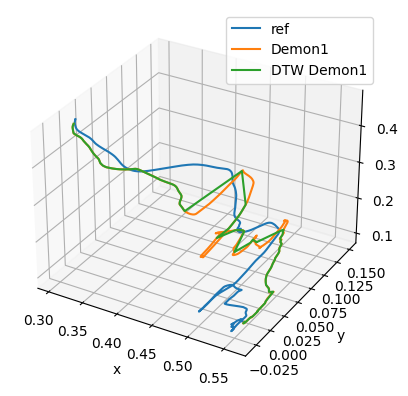

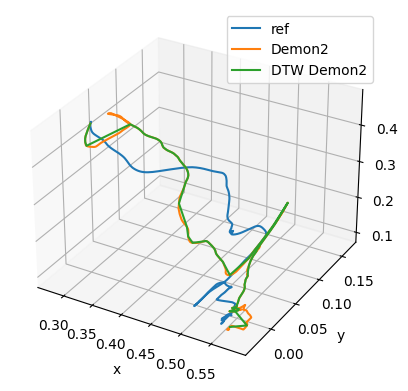

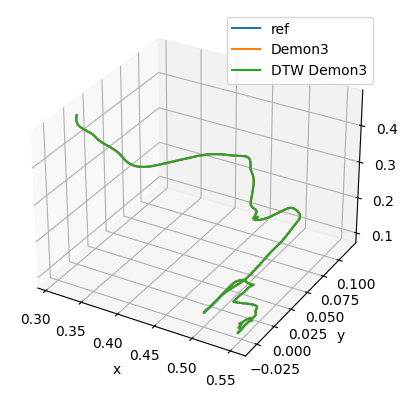

In [137]:
%matplotlib inline
# %matplotlib qt

print("Reference Demon:")
ref_demon = str(3)
ref_arr_Data = np.loadtxt(TPGMM_dir + "Demon" + ref_demon + "_sample_Data.txt", delimiter=',')
print(ref_arr_Data.shape)

for d in range(1,4):
    demon_num = str(d)
    
    print("DTWinng..")
    temp_arr_Data = np.loadtxt(TPGMM_dir + "Demon" + demon_num + "_sample_Data.txt", delimiter=',')
    print(temp_arr_Data.shape)

    DTW = dtw(temp_arr_Data[1:,:].T, ref_arr_Data[1:,:].T)
    wq = warp(DTW, index_reference=False)
    print(wq.shape)

    ## Plotting
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    ax.plot(ref_arr_Data[1,:], ref_arr_Data[2,:], ref_arr_Data[3,:], label='ref')
    ax.plot(temp_arr_Data[1,:], temp_arr_Data[2,:], temp_arr_Data[3,:], label='Demon{}'.format(d))
    ax.plot(temp_arr_Data[1,wq], temp_arr_Data[2,wq], temp_arr_Data[3,wq], label='DTW Demon{}'.format(d))
    
    ax.legend()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ## Saving in .txt
    np.savetxt(TPGMM_dir + "Demon" + demon_num + "_sample_Data.txt", temp_arr_Data[:,wq], fmt='%.5f') # cut out the 1st column (zeros) that was created only to initialize the array 
    with open(r"{}".format(TPGMM_dir) + "Demon" + demon_num + "_sample_Data.txt", 'r') as f: # The 'r' before the directory name is to open the file as read-only
        data = f.read(); data = data.replace(' ', ',')
    with open(r"{}".format(TPGMM_dir) + "Demon" + demon_num + "_sample_Data.txt", 'w') as f:
        f.write(data)

    ## Only for debuggin to check the txt file shape
    print("Debugging")
    temp_arr_Data = np.loadtxt(TPGMM_dir + "Demon" + demon_num + "_sample_Data.txt", delimiter=',')
    print(temp_arr_Data.shape)
    print("\n")
    


### DTW testing example

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 18 19 19 20 20 20 21 21 21 22 22 23 24 24 25 25 25 26 26
 27 27 27 28 28 29 29 30 30 31 31 31 31 32 32 32 32 32 32 32 32 33 34 35
 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 68 68 68 68 68 68 68 68 69 69 70 70 71 72 72
 72 73 73 74 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93
 94 95 96 97 98 99 99]
175
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
100


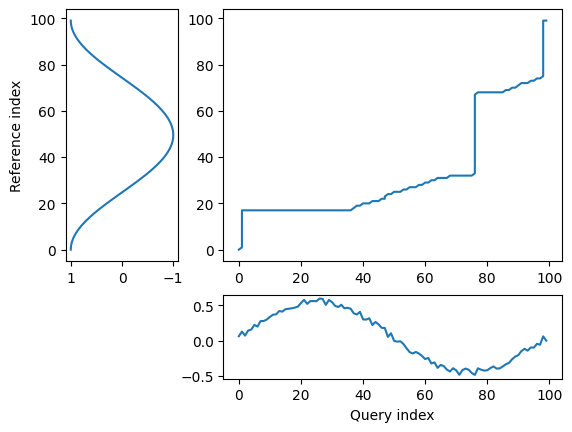

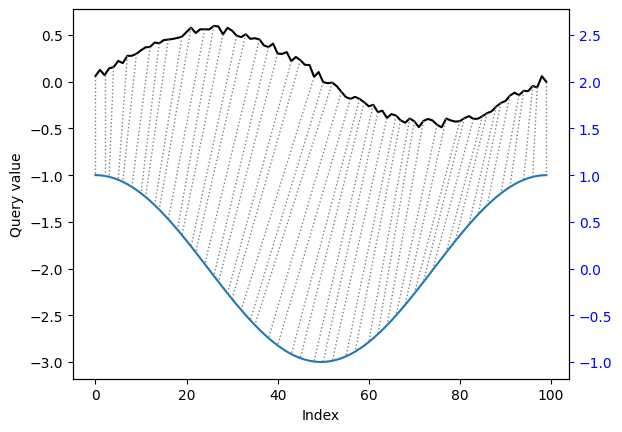

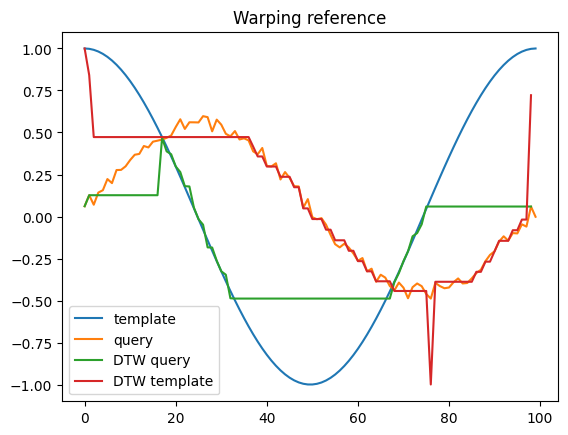

In [75]:
%matplotlib inline
# %matplotlib qt

## A noisy sine wave as query
idx = np.linspace(0,6.28,num=100)
query = (1/2)*np.sin(idx) + np.random.uniform(size=100)/10.0

## A cosine is for template; sin and cos are offset by 25 samples
template = np.cos(idx)

## Find the best match with the canonical recursion formula
from dtw import *
alignment = dtw(query, template, dist_method='euclidean', step_pattern='symmetric2',
                window_type=None, window_args={}, keep_internals=True, distance_only=False, open_end=False, open_begin=False)

## Display the warping curve, i.e. the alignment curve
alignment.plot(type="threeway")

## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
dtw(query, template, keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2)

## See the recursion relation, as formula and diagram
# print(rabinerJuangStepPattern(6,"c"))
# rabinerJuangStepPattern(6,"c").plot()

## And much more!
indx = alignment.index2

print(indx)
print(len(indx))
print(list(set(indx)))
print(len(list(set(indx))))

plt.figure(0)
# plt.scatter(indx, query[indx], label="DTW query")
# plt.plot(query, label="query")
# plt.plot(template, label="template")

wq = warp(alignment,index_reference=False)
wt = warp(alignment,index_reference=True)

plt.plot(template, label="template")
plt.plot(query, label="query")

plt.plot(query[wq], label="DTW query")
plt.gca().set_title("Warping query")

plt.plot(template[wt], label="DTW template")
plt.gca().set_title("Warping reference")

plt.legend()
plt.show()